Google Analytics Customer Revenue Prediction

•	fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
•	channelGrouping - The channel via which the user came to the Store.
•	date - The date on which the user visited the Store.
•	device - The specifications for the device used to access the Store.
•	geoNetwork - This section contains information about the geography of the user.
•	socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
•	totals - This section contains aggregate values across the session.
•	trafficSource - This section contains information about the Traffic Source from which the session originated.
•	visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
•	visitNumber - The session number for this user. If this is the first session, then this is set to 1.
•	visitStartTime - The timestamp (expressed as POSIX time).
•	hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
•	customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
•	totals - This set of columns mostly includes high-level aggregate data.


In [0]:
!pip  install libmpfr-dev
!pip install bigfloat

ERROR: Could not find a version that satisfies the requirement libmpfr-dev (from versions: none)
ERROR: No matching distribution found for libmpfr-dev
  Using cached https://files.pythonhosted.org/packages/e0/6c/34784aecbd34d8eaad938106a8b0e5af57dc7282baf613cb8414ef949c20/bigfloat-0.4.0.tar.gz
  ERROR: Failed building wheel for bigfloat
  Running setup.py clean for bigfloat
Failed to build bigfloat
    Running setup.py install for bigfloat ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-lt2pm83r/bigfloat/setup.py'"'"'; __file__='"'"'/tmp/pip-install-lt2pm83r/bigfloat/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-hsn285wd/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [0]:
import random # random is to generate random values

import pandas as pd # to manipulate data frames 
import numpy as np # to work with matrix
from scipy.stats import kurtosis, skew # it's to explore some statistics of numerical values

import matplotlib.pyplot as plt # to graphics plot
import seaborn as sns # a good library to graphic plots
#import squarify # to better understand proportion of categorys - it's a treemap layout algorithm

# Importing librarys to use on interactive graphs
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

import json # to convert json in df
from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
import sys
import csv

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


we see device,geoNetwork,totals,trafficSource in the form of JSON.
so we need to convert all these into columns

In [0]:
def convert_df_columns_train():
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    csv_path='/content/drive/My Drive/google-pred-data/test_v2.csv'
    nrows=None
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [0]:
def convert_df_columns_train_test():
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    csv_path='/content/drive/My Drive/google-pred-data/test_v2.csv'
    nrows=None
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [0]:
def get_na_count(df):
    print(df.shape)
    print(df.isna().sum())

In [0]:
def get_not_available_data_columns(df):
    print("device.browserVersion-not available in demo dataset",df['device.browserVersion'].str.contains(r'not available in demo dataset').sum())
    print("device.browserSize-not available in demo dataset",df['device.browserSize'].str.contains(r'not available in demo dataset').sum())
    print("device.operatingSystemVersion-not available in demo dataset",df['device.operatingSystemVersion'].str.contains(r'not available in demo dataset').sum())
    print("device.mobileDeviceBranding-not available in demo dataset",df['device.mobileDeviceBranding'].str.contains(r'not available in demo dataset').sum())
    print("device.mobileDeviceModel-not available in demo dataset",df['device.mobileDeviceModel'].str.contains(r'not available in demo dataset').sum())
    print("device.mobileInputSelector-not available in demo dataset",df['device.mobileInputSelector'].str.contains(r'not available in demo dataset').sum())
    print("device.mobileDeviceInfo-not available in demo dataset",df['device.mobileDeviceInfo'].str.contains(r'not available in demo dataset').sum())
    print("device.mobileDeviceMarketingName-not available in demo dataset",df['device.mobileDeviceMarketingName'].str.contains(r'not available in demo dataset').sum())
    print("device.flashVersion-not available in demo dataset",df['device.flashVersion'].str.contains(r'not available in demo dataset').sum())
    print("device.language-not available in demo dataset",df['device.language'].str.contains(r'not available in demo dataset').sum())
    print("device.screenColors-not available in demo dataset",df['device.screenColors'].str.contains(r'not available in demo dataset').sum())
    print("device.screenResolution-not available in demo dataset",df['device.screenResolution'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.region-not available in demo dataset",df['geoNetwork.region'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.metro-not available in demo dataset",df['geoNetwork.metro'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.city-not available in demo dataset",df['geoNetwork.city'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.cityId-not available in demo dataset",df['geoNetwork.cityId'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.networkDomain-unknown.unknown",df['geoNetwork.networkDomain'].str.contains(r'unknown.unknown').sum())
    print("geoNetwork.latitude-not available in demo dataset",df['geoNetwork.latitude'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.longitude-not available in demo dataset",df['geoNetwork.longitude'].str.contains(r'not available in demo dataset').sum())
    print("geoNetwork.networkLocation-not available in demo dataset",df['geoNetwork.networkLocation'].str.contains(r'not available in demo dataset').sum())
    print("trafficSource.adwordsClickInfo.criteriaParameters-not available in demo dataset",df['trafficSource.adwordsClickInfo.criteriaParameters'].str.contains(r'not available in demo dataset').sum())
    print("trafficSource.campaign-not set",df['trafficSource.campaign'].str.contains(r'(not set)').sum())

#let's remove all these columns

In [0]:
def drop_unwanted_col(df):
    df.drop(['totals.bounces','trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','trafficSource.adwordsClickInfo.page', 
    'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adContent','trafficSource.campaignCode','Unnamed: 0','totals.sessionQualityDim','totals.timeOnSite','totals.totalTransactionRevenue','totals.transactions'],axis=1, inplace=True)
             
    df.drop(['device.browserVersion','device.browserSize','device.operatingSystemVersion','device.mobileDeviceBranding','device.isMobile','device.mobileDeviceModel',
    'device.mobileInputSelector','device.mobileDeviceInfo','device.mobileDeviceMarketingName','device.flashVersion','device.language','device.screenColors',
    'device.screenResolution','geoNetwork.region','geoNetwork.metro','geoNetwork.city','geoNetwork.cityId','geoNetwork.networkDomain','geoNetwork.latitude',
    'geoNetwork.longitude','geoNetwork.networkLocation','trafficSource.adwordsClickInfo.criteriaParameters','trafficSource.campaign'],axis=1, inplace=True)
    return df

In [0]:
def drop_unwanted_col_test(df):
    df.drop(['totals.bounces','trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','trafficSource.adwordsClickInfo.page', 
    'trafficSource.adwordsClickInfo.slot','trafficSource.adwordsClickInfo.gclId','trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.isVideoAd','trafficSource.adContent','Unnamed: 0','totals.sessionQualityDim','totals.timeOnSite','totals.totalTransactionRevenue','totals.transactions','totals.transactionRevenue' ],axis=1, inplace=True)
    df.drop(['device.browserVersion','device.browserSize','device.operatingSystemVersion','device.mobileDeviceBranding','device.isMobile','device.mobileDeviceModel',
    'device.mobileInputSelector','device.mobileDeviceInfo','device.mobileDeviceMarketingName','device.flashVersion','device.language','device.screenColors',
    'device.screenResolution','geoNetwork.region','geoNetwork.metro','geoNetwork.city','geoNetwork.cityId','geoNetwork.networkDomain','geoNetwork.latitude',
    'geoNetwork.longitude','geoNetwork.networkLocation','trafficSource.adwordsClickInfo.criteriaParameters','trafficSource.campaign'],axis=1, inplace=True)
    
    return df

In [0]:
def column_renaming(df):
    df.rename(columns={'device.browser': 'device_browser', 'device.operatingSystem': 'device_operatingSystem','device.deviceCategory':'device_deviceCategory','geoNetwork.continent':'geoNetwork_continent','geoNetwork.subContinent':'geoNetwork_subContinent','geoNetwork.country':'geoNetwork_country','totals.visits':'totals_visits','totals.hits':'totals_hits','totals.pageviews':'totals_pageviews','totals.newVisits':'totals_newVisits','totals.transactionRevenue':'totals_transactionRevenue','trafficSource.source':'trafficSource_source','trafficSource.medium':'trafficSource_medium'}, inplace=True)
    return df

In [0]:
def column_renaming_test(df):
    df.rename(columns={'device.browser': 'device_browser', 'device.operatingSystem': 'device_operatingSystem','device.deviceCategory':'device_deviceCategory','geoNetwork.continent':'geoNetwork_continent','geoNetwork.subContinent':'geoNetwork_subContinent','geoNetwork.country':'geoNetwork_country','totals.visits':'totals_visits','totals.hits':'totals_hits','totals.pageviews':'totals_pageviews','totals.newVisits':'totals_newVisits','trafficSource.source':'trafficSource_source','trafficSource.medium':'trafficSource_medium'}, inplace=True)
    return df

In [0]:
#first change date format to yyymmdd and then create three columns year,month and day
def date_extraction(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')
    df['year'] = df['date'].apply(lambda x: x.year)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['day'] = df['date'].apply(lambda x: x.day)
    df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
    df.drop(['date','visitStartTime'],axis=1, inplace=True)
    return df

In [0]:
def handle_na_values(df):
    #1.in geo_network data some values are not set values those will be handled when we will convert them to numerical data
    #2.device same all will be taken care at time of numerical data conversion
    #3.traffic source
    #4.visitNumber
    #totals.newVisits
    df["totals_newVisits"].fillna(0, inplace=True)
    #totals.pageviews
    df["totals_pageviews"].fillna(1, inplace=True)
    #totals.transactionRevenue
    df["totals_transactionRevenue"].replace('', 0, inplace=True)
    df["totals_transactionRevenue"].fillna(0, inplace=True)
    df['totals_transactionRevenue'] = np.log1p(df['totals_transactionRevenue'].astype(float))

    df["totals_newVisits"]=df["totals_newVisits"].astype(int)
    df["totals_pageviews"]=df["totals_pageviews"].astype(int)
    df["visitNumber"]=df["visitNumber"].astype(int)
    df["totals_visits"]=df["totals_visits"].astype(int)
    df["totals_hits"]=df["totals_hits"].astype(int)
    df["totals_transactionRevenue"]=df["totals_transactionRevenue"].astype(int)

    return df


In [0]:
def handle_na_values_test(df):
    #1.in geo_network data some values are not set values those will be handled when we will convert them to numerical data
    #2.device same all will be taken care at time of numerical data conversion
    #3.traffic source
    #4.visitNumber
    #totals.newVisits
    df["totals_newVisits"].fillna(0, inplace=True)
    #totals.pageviews
    df["totals_pageviews"].fillna(1, inplace=True)
    #totals.transactionRevenue
    

    df["totals_newVisits"]=df["totals_newVisits"].astype(int)
    df["totals_pageviews"]=df["totals_pageviews"].astype(int)
    df["visitNumber"]=df["visitNumber"].astype(int)
    df["totals_visits"]=df["totals_visits"].astype(int)
    df["totals_hits"]=df["totals_hits"].astype(int)
    

    return df


In [0]:
def add_new_features(df):
    #first feature we can add is mean hits by user per day basis
    df['sum_visits_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_visits'].transform('sum')
    df['mean_visits_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_visits'].transform('mean')
    df['sum_hits_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_hits'].transform('sum')
    df['mean_hits_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_visits'].transform('mean')
    df['sum_pageviews_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_pageviews'].transform('sum')
    df['mean_pageviews_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_pageviews'].transform('mean')
    df['sum_newvisits_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_newVisits'].transform('sum')
    df['mean_newvists_per_day']=df.groupby(['fullVisitorId','year','month','day'])['totals_newVisits'].transform('mean')

    return df

In [0]:
def feature_engineering(df):
    colnames_numerics_only = df.select_dtypes(include=np.number).columns.tolist()
    print(colnames_numerics_only)
    categorical_cols=[col for col in df.columns if col not in colnames_numerics_only  and col not in ['fullVisitorId', 'sessionId']]
    print(categorical_cols)
    for col in categorical_cols:
        #print("transform column {}".format(col))
        lbe = LabelEncoder()
        lbe.fit(df[col].astype('str'))
        df[col] = lbe.transform(df[col].astype('str'))
    return df

In [0]:
num_feat=['visitNumber','totals_visits','totals_hits','totals_pageviews','totals_newVisits']
def feature_engineering_numercal(df):
    for col in num_feat:
        robust_scaler = RobustScaler()
        df[col] = robust_scaler.fit_transform(df)
    return df

In [0]:
df.drop(['date','fullVisitorId','sessionId','visitId','visitStartTime'],axis=1, inplace=True)

In [0]:
df.to_csv(r'/content/drive/My Drive/gstore_preprocessed_data_test.csv', index = None, header=True)

In [0]:
train=pd.read_csv(r'/content/drive/My Drive/gstore_preprocessed_data.csv')
test=pd.read_csv(r'/content/drive/My Drive/gstore_preprocessed_data_test.csv')

In [0]:
df.to_csv(r'/content/drive/My Drive/gstore_preprocessed_data_test.csv', index = None, header=True)

In [0]:
df=pd.read_csv("/content/drive/My Drive/gstore_preprocessed_data.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



In [0]:
df.drop(['date','fullVisitorId','sessionId','visitId','visitStartTime','mean_hits_per_day','mean_pageviews_per_day','sum_hits_per_day','sum_pageviews_per_day'],axis=1, inplace=True)

# Process Data

In [0]:
#since file size is too large we need to increasecsv limit
csv.field_size_limit(sys.maxsize)

131072

In [0]:
df_train=convert_df_columns_train()

In [0]:
df_test=convert_df_columns_train()

In [0]:
df_train.to_csv(r'/content/drive/My Drive/train_google_2.csv', index = None, header=True)

In [0]:
df_test.to_csv(r'/content/drive/My Drive/test_google_2.csv', index = None, header=True)

In [0]:
#Preprocess train data

In [0]:
df=pd.read_csv('/content/drive/My Drive/train_google_2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (19,50) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
df.head(5)

,Unnamed: 0,channelGrouping,date,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,fullVisitorId,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,socialEngagementType,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.totalTransactionRevenue,totals.transactionRevenue,totals.transactions,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
0,0,Organic Search,20171016,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,3162355547410993243,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,Not Socially Engaged,1.0,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google,1508198450,1,1508198450
1,1,Referral,20171016,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,8934116514970143966,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,Not Socially Engaged,NaN,2,NaN,2.0,2.0,28.0,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,1508176307,6,1508176307
2,2,Direct,20171016,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,7992466427990357681,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,Northern America,Not Socially Engaged,NaN,2,1.0,2.0,1.0,38.0,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,(none),NaN,(direct),1508201613,1,1508201613
3,3,Organic Search,20171016,Chrome

In [0]:
#this function gives you NA count
get_na_count(df)

(1708337, 59)
Unnamed: 0                                                 0
channelGrouping                                            0
date                                                       0
device.browser                                             0
device.browserSize                                         0
device.browserVersion                                      0
device.deviceCategory                                      0
device.flashVersion                                        0
device.isMobile                                            0
device.language                                            0
device.mobileDeviceBranding                                0
device.mobileDeviceInfo                                    0
device.mobileDeviceMarketingName                           0
device.mobileDeviceModel                                   0
device.mobileInputSelector                                 0
device.operatingSystem                                     0
device.ope

In [0]:
#there are some columns which have column value as not available in demo
get_not_available_data_columns(df)

device.browserVersion-not available in demo dataset 401589
device.browserSize-not available in demo dataset 401589
device.operatingSystemVersion-not available in demo dataset 401589
device.mobileDeviceBranding-not available in demo dataset 401589
device.mobileDeviceModel-not available in demo dataset 401589
device.mobileInputSelector-not available in demo dataset 401589
device.mobileDeviceInfo-not available in demo dataset 401589
device.mobileDeviceMarketingName-not available in demo dataset 401589
device.flashVersion-not available in demo dataset 401589
device.language-not available in demo dataset 401589
device.screenColors-not available in demo dataset 401589
device.screenResolution-not available in demo dataset 401589
geoNetwork.region-not available in demo dataset 206434
geoNetwork.metro-not available in demo dataset 206434
geoNetwork.city-not available in demo dataset 206434
geoNetwork.cityId-not available in demo dataset 401589
geoNetwork.networkDomain-unknown.unknown 56949
geoN

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [0]:
df=drop_unwanted_col_test(df)

In [0]:
#let's sum up and remove all these columns
df=drop_unwanted_col(df)

In [0]:
df.columns

Index(['channelGrouping', 'date', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'fullVisitorId', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent', 'socialEngagementType',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'totals.visits', 'trafficSource.medium',
       'trafficSource.source', 'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

In [0]:
#this columns extract date from timestamp
df=date_extraction(df)

In [0]:
df.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'fullVisitorId', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent', 'socialEngagementType',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue', 'totals.visits', 'trafficSource.medium',
       'trafficSource.source', 'visitId', 'visitNumber', 'year', 'month',
       'day'],
      dtype='object')

In [0]:
df=column_renaming(df)

In [0]:
df=column_renaming_test(df)

In [0]:
df=handle_na_values(df)

In [0]:
df.shape

(1708337, 21)

In [0]:
df.columns

Index(['channelGrouping', 'device_browser', 'device_deviceCategory',
       'device_operatingSystem', 'fullVisitorId', 'geoNetwork_continent',
       'geoNetwork_country', 'geoNetwork_subContinent', 'socialEngagementType',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_transactionRevenue', 'totals_visits', 'trafficSource_medium',
       'trafficSource_source', 'visitId', 'visitNumber', 'year', 'month',
       'day'],
      dtype='object')

In [0]:
df.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,fullVisitorId,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_medium,trafficSource_source,visitId,visitNumber,year,month,day
680923,Organic Search,Chrome,desktop,Macintosh,259678714014,Americas,United States,Northern America,Not Socially Engaged,16,0,10,0,1,organic,google,1511914780,2,2017,11,28
683687,Organic Search,Chrome,desktop,Macintosh,259678714014,Americas,United States,Northern America,Not Socially Engaged,3,1,3,0,1,organic,google,1511912001,1,2017,11,28


In [0]:
df=add_new_features(df)

In [0]:
df=feature_engineering(df)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_subContinent', 'socialEngagementType', 'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue', 'totals_visits', 'trafficSource_medium', 'trafficSource_source', 'year', 'month', 'day', 'sum_visits_per_day', 'mean_visits_per_day', 'sum_hits_per_day', 'mean_hits_per_day', 'sum_pageviews_per_day', 'mean_pageviews_per_day', 'sum_newvisits_per_day', 'mean_newvists_per_day']


In [0]:
df.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,fullVisitorId,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_medium,trafficSource_source,visitId,visitNumber,year,month,day,sum_visits_per_day,mean_visits_per_day,sum_hits_per_day,mean_hits_per_day,sum_pageviews_per_day,mean_pageviews_per_day,sum_newvisits_per_day,mean_newvists_per_day
680923,4,35,0,7,259678714014,2,218,12,0,67,0,1,0,0,5,99,1511914780,2,1,2,20,8,0,100,0,34,551,1,10
683687,4,35,0,7,259678714014,2,218,12,0,184,1,131,0,0,5,99,1511912001,1,1,2,20,8,0,100,0,34,551,1,10


In [0]:
df.drop(['fullVisitorId','visitId'],axis=1, inplace=True)

In [0]:
df.shape

(1708337, 27)

In [0]:
df=feature_engineering_numercal(df)

In [0]:
df.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue,totals_visits,trafficSource_medium,trafficSource_source,visitNumber,year,month,day,sum_visits_per_day,mean_visits_per_day,sum_hits_per_day,mean_hits_per_day,sum_pageviews_per_day,mean_pageviews_per_day,sum_newvisits_per_day,mean_newvists_per_day
680923,4,35,0,7,2,218,12,0,0.0,0.0,0.0,0,0.0,5,99,0.0,1,2,20,8,0,100,0,34,551,1,10
683687,4,35,0,7,2,218,12,0,0.0,0.0,0.0,0,0.0,5,99,0.0,1,2,20,8,0,100,0,34,551,1,10


In [0]:
df.shape

(1708337, 27)

In [0]:
#storing preprocessed data to google drive
df.to_csv(r'/content/drive/My Drive/gstore_preprocessed_data_test.csv', index = None, header=True)

#Processing test data 

In [0]:
df_test=pd.read_csv('/content/drive/My Drive/test_google_2.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.



In [0]:
get_na_count(df_test)

(401589, 58)
Unnamed: 0                                                0
channelGrouping                                           0
date                                                      0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                                   0
device.mobileDeviceMarketingName                          0
device.mobileDeviceModel                                  0
device.mobileInputSelector                                0
device.operatingSystem                                    0
device.operatingSystemVersi

In [0]:
get_not_available_data_columns(df_test)

device.browserVersion-not available in demo dataset 401589
device.browserSize-not available in demo dataset 401589
device.operatingSystemVersion-not available in demo dataset 401589
device.mobileDeviceBranding-not available in demo dataset 401589
device.mobileDeviceModel-not available in demo dataset 401589
device.mobileInputSelector-not available in demo dataset 401589
device.mobileDeviceInfo-not available in demo dataset 401589
device.mobileDeviceMarketingName-not available in demo dataset 401589
device.flashVersion-not available in demo dataset 401589
device.language-not available in demo dataset 401589
device.screenColors-not available in demo dataset 401589
device.screenResolution-not available in demo dataset 401589
geoNetwork.region-not available in demo dataset 206434
geoNetwork.metro-not available in demo dataset 206434
geoNetwork.city-not available in demo dataset 206434
geoNetwork.cityId-not available in demo dataset 401589
geoNetwork.networkDomain-unknown.unknown 56949
geoN

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



In [0]:
df_test=drop_unwanted_col_test(df_test)

In [0]:
df_test.columns

Index(['channelGrouping', 'date', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'fullVisitorId', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent', 'socialEngagementType',
       'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.medium', 'trafficSource.source', 'visitId',
       'visitNumber', 'visitStartTime'],
      dtype='object')

In [0]:
df_test=date_extraction(df_test)

In [0]:
df_test.columns

Index(['channelGrouping', 'device.browser', 'device.deviceCategory',
       'device.operatingSystem', 'fullVisitorId', 'geoNetwork.continent',
       'geoNetwork.country', 'geoNetwork.subContinent', 'socialEngagementType',
       'totals.hits', 'totals.newVisits', 'totals.pageviews', 'totals.visits',
       'trafficSource.medium', 'trafficSource.source', 'visitId',
       'visitNumber', 'year', 'month', 'day'],
      dtype='object')

In [0]:
df_test=column_renaming_test(df_test)

In [0]:
df_test=handle_na_values_test(df_test)

In [0]:
df_test.shape

(401589, 20)

In [0]:
df_test.columns

Index(['channelGrouping', 'device_browser', 'device_deviceCategory',
       'device_operatingSystem', 'fullVisitorId', 'geoNetwork_continent',
       'geoNetwork_country', 'geoNetwork_subContinent', 'socialEngagementType',
       'totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_visits',
       'trafficSource_medium', 'trafficSource_source', 'visitId',
       'visitNumber', 'year', 'month', 'day'],
      dtype='object')

In [0]:
df_test.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,fullVisitorId,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_visits,trafficSource_medium,trafficSource_source,visitId,visitNumber,year,month,day
258890,Organic Search,Chrome,mobile,Android,1995526696366,Asia,Taiwan,Eastern Asia,Not Socially Engaged,5,1,4,1,organic,google,1536654515,1,2018,9,11
263903,Direct,Chrome,desktop,Windows,16367580689231,Americas,Canada,Northern America,Not Socially Engaged,2,1,2,1,(none),(direct),1534170866,1,2018,8,13


In [0]:
df_test=add_new_features(df_test)

In [0]:
df_test=feature_engineering(df_test)

['totals_hits', 'totals_newVisits', 'totals_pageviews', 'totals_visits', 'visitId', 'visitNumber', 'year', 'month', 'day', 'sum_visits_per_day', 'mean_visits_per_day', 'sum_hits_per_day', 'mean_hits_per_day', 'sum_pageviews_per_day', 'mean_pageviews_per_day', 'sum_newvisits_per_day', 'mean_newvists_per_day']
['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_subContinent', 'socialEngagementType', 'trafficSource_medium', 'trafficSource_source']


In [0]:
df_test.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,fullVisitorId,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_visits,trafficSource_medium,trafficSource_source,visitId,visitNumber,year,month,day,sum_visits_per_day,mean_visits_per_day,sum_hits_per_day,mean_hits_per_day,sum_pageviews_per_day,mean_pageviews_per_day,sum_newvisits_per_day,mean_newvists_per_day
258890,4,25,1,1,1995526696366,3,185,6,0,5,1,4,1,5,62,1536654515,1,2018,9,11,1,1,5,1,4,4.0,1,1.0
263903,2,25,0,18,16367580689231,2,35,12,0,2,1,2,1,0,0,1534170866,1,2018,8,13,1,1,2,1,2,2.0,1,1.0


In [0]:
df_test.drop(['fullVisitorId','visitId'],axis=1, inplace=True)

In [0]:
df_test.shape

(401589, 26)

In [0]:
df_test=feature_engineering_numercal(df_test)

In [0]:
df_test.head(2)

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,geoNetwork_continent,geoNetwork_country,geoNetwork_subContinent,socialEngagementType,totals_hits,totals_newVisits,totals_pageviews,totals_visits,trafficSource_medium,trafficSource_source,visitNumber,year,month,day,sum_visits_per_day,mean_visits_per_day,sum_hits_per_day,mean_hits_per_day,sum_pageviews_per_day,mean_pageviews_per_day,sum_newvisits_per_day,mean_newvists_per_day
258890,4,25,1,1,3,185,6,0,0.0,0.0,0.0,0.0,5,62,0.0,2018,9,11,1,1,5,1,4,4.0,1,1.0
263903,2,25,0,18,2,35,12,0,-2.0,-2.0,-2.0,-2.0,0,0,-2.0,2018,8,13,1,1,2,1,2,2.0,1,1.0


In [0]:
df_test.shape

(401589, 26)

In [0]:
df_test.to_csv(r'/content/drive/My Drive/gstore_preprocessed_data_test.csv', index = None, header=True)

In [0]:
df_train=pd.read_csv('/content/drive/My Drive/gstore_preprocessed_data_train.csv')
X_test=pd.read_csv('/content/drive/My Drive/gstore_preprocessed_data_test.csv')

In [0]:
X_test.shape

(401589, 26)

In [0]:
Y_train_reg = df_train.pop('totals_transactionRevenue')
#Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = df_train

#Clustering

In [0]:
from sklearn import cluster
colors = np.array(['orange', 'blue', 'lime', 'blue', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [0]:
X_train_cluster=X_train[0:2000]

In [0]:
#BOW
Sum_of_squared_distances_bow = []
K = range(3,15)
for k in K:
    km = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(X_train_cluster)
    #km = km.fit(X_train)
    Sum_of_squared_distances_bow.append(km.inertia_)

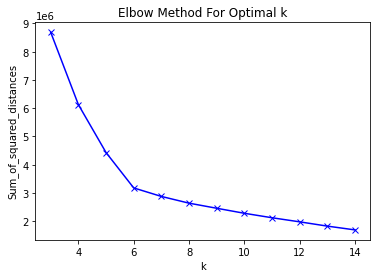

In [0]:
plt.plot(K, Sum_of_squared_distances_bow, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
k=6
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(X_train_cluster)

In [0]:
data_and_centers = np.r_[X_train_cluster,clustered_data_sklearn.cluster_centers_]

In [0]:
from sklearn import manifold
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


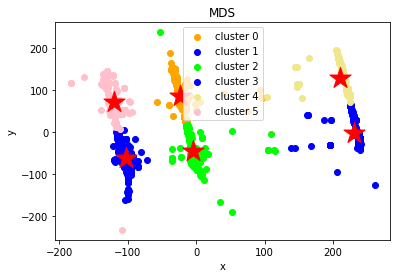

In [0]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

We have applied K-means clustering technique to visualize the dataset.We applied elbow method to get the best value of k and we got k=6 as the best k value where K means number of clusters.To visualize it, we have converted it into 2-dimensional data using Manifold dimensionality reduction technique.A you can see that many points are far from their clusters so we can analyse that the data is not so smooth.We have to apply smome techniques like Robust Scalar to improve the scaling of numerical data.
*Note- Due to hardware limitation we are able to do clustering of only 2000 data points.So observation might be not that accurate

In [0]:
train_new=pd.read_csv('/content/drive/My Drive/train_google_2.csv',dtype={'fullVisitorId': 'str'})
test_new=pd.read_csv('/content/drive/My Drive/test_google_2.csv',dtype={'fullVisitorId': 'str'})
train_id = train_new['fullVisitorId']
test_id = test_new['fullVisitorId']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (50) have mixed types.Specify dtype option on import or set low_memory=False.



#LGBM

In [0]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
params={'learning_rate': 0.01,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.6,
        'feature_fraction': 0.6
       }

folds = GroupKFold(n_splits=5)

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train_reg, groups=train_id)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train_reg.iloc[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration_) / folds.n_splits

pred = sub_preds

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.50796
[1000]	valid_0's rmse: 1.50046
[1500]	valid_0's rmse: 1.49736
Early stopping, best iteration is:
[1824]	valid_0's rmse: 1.49592
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.48383
[1000]	valid_0's rmse: 1.47631
[1500]	valid_0's rmse: 1.47297
[2000]	valid_0's rmse: 1.47071
[2500]	valid_0's rmse: 1.46926
Early stopping, best iteration is:
[2462]	valid_0's rmse: 1.46924
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.47911
[1000]	valid_0's rmse: 1.47172
[1500]	valid_0's rmse: 1.46774
[2000]	valid_0's rmse: 1.46601
Early stopping, best iteration is:
[2309]	valid_0's rmse: 1.46541
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.47743
[1000]	valid_0's rmse: 1.46932
[1500]	valid_0's rmse: 1.46545
[2000]	valid_0's rmse: 1.46291
[2500]	valid_0's rmse: 1.46149
Early stopping, best iteration 

In [0]:
import pickle 
filename = '/content/drive/My Drive/model/google_model1.pkl'
saved_model = pickle.dump(LGBM_grid,open('/content/drive/My Drive/google_model1.pkl','wb')) 

In [0]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("/content/drive/My Drive/submission.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000003
1,0000039738481224681,0.000000
2,0000073585230191399,0.005182
3,0000087588448856385,0.000000
4,0000149787903119437,0.000000
5,0000196310838896290,0.000000
6,00001995526696366,0.000000
7,0000255704530917106,0.000152
8,0000268499301061358,0.000000
9,0000276747989270229,0.000000


#XGBRegressor

In [0]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,200,500]}

xgb_grid = GridSearchCV(xgb1,parameters,cv = 2,verbose=True)
xgb_grid.fit(X_train,Y_train_reg)

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
xgb_best = xgb.XGBRegressor(colsample_bytree= 0.7,learning_rate= 0.03,max_depth= 5,min_child_weight= 4,n_estimators= 500,nthread= 4,silent= 1, subsample =0.7)
xgb_best.fit(X_train,Y_train_reg)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=500,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
             subsample=0.7, verbosity=1)

In [0]:
pred_xgb=xgb_best.predict(X_test)

In [0]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred_xgb})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("/content/drive/My Drive/gsubmission_xgb.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.003535
1,0000039738481224681,0.000000
2,0000073585230191399,0.010272
3,0000087588448856385,0.002215
4,0000149787903119437,0.003911
5,0000196310838896290,0.002708
6,00001995526696366,0.000000
7,0000255704530917106,0.000000
8,0000268499301061358,0.001177
9,0000276747989270229,0.000062


#GradientBoostingRegressor

In [0]:
 from sklearn.ensemble import GradientBoostingRegressor
 from sklearn.model_selection import GridSearchCV
 model_gbr = GradientBoostingRegressor()
parameters = {
                  
                  'n_estimators' : [50,100,200,300,500,1000],
                   
                 }
grid_gbr = GridSearchCV(estimator=model_gbr, param_grid = parameters, cv = 3)
grid_gbr.fit(X_train_xgb,Y_train_xgb)

GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [0]:
print(grid_gbr.best_score_)
print(grid_gbr.best_params_)

0.29247773272232325
{'n_estimators': 200}


In [0]:
from sklearn.ensemble import GradientBoostingRegressor
 
gbr_best = GradientBoostingRegressor(n_estimators= 200)
gbr_best.fit(X_train,Y_train_reg)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
pred_gbr=gbr_best.predict(X_test)

In [0]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred_gbr})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("/content/drive/My Drive/gsubmission_gbr.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000000
1,0000039738481224681,0.000000
2,0000073585230191399,0.003470
3,0000087588448856385,0.003460
4,0000149787903119437,0.000000
5,0000196310838896290,0.000000
6,00001995526696366,0.000000
7,0000255704530917106,0.000000
8,0000268499301061358,0.002599
9,0000276747989270229,0.000000


#ElasticNetRegressor

In [0]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
model_elastic = ElasticNet()
parameters = {
                  
                  'alpha' : [10**-3,10**-2, 10**-1, 10**0,10**1,10**2, 10**3]
                   
                 }
grid_elastic = GridSearchCV(estimator=model_elastic, param_grid = parameters, cv = 3)
grid_elastic.fit(X_train_xgb,Y_train_xgb)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 29673.35711989127, tolerance: 63.93482623800147

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21892.578716227436, tolerance: 65.93461409549762

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 74945.0371683978, tolerance: 66.20370917950497

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 65.42741909995675, tolerance: 63.93482623

GridSearchCV(cv=3, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print(grid_elastic.best_score_)
print(grid_elastic.best_params_)

0.15292771773443958
{'alpha': 0.001}


In [0]:
gbr_elastic = ElasticNet(alpha= 0.001)
gbr_elastic.fit(X_train,Y_train_reg)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 92859.32665185072, tolerance: 548.2383728450334



ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
pred_elastic=gbr_elastic.predict(X_test)

In [0]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred_elastic})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("/content/drive/My Drive/gsubmission_elastic.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.489318
1,0000039738481224681,0.025847
2,0000073585230191399,0.455509
3,0000087588448856385,0.000000
4,0000149787903119437,0.464465
5,0000196310838896290,0.401357
6,00001995526696366,0.000000
7,0000255704530917106,0.000000
8,0000268499301061358,0.000000
9,0000276747989270229,0.507894


#Conclusion

In [0]:
from prettytable import PrettyTable
x = PrettyTable()

In [0]:
x.field_names = ["Type of regressor", "Kaggle Score"]

In [0]:
x.add_row(["LGBM Regressor","0.88996"])
x.add_row(["XGB Regressor","0.88945"])
x.add_row(["GBR Regressor","0.89488"])
x.add_row(["Elastic Regressor","0.92424"])

In [0]:
print(x)

+-------------------+--------------+
| Type of regressor | Kaggle Score |
+-------------------+--------------+
|   LGBM Regressor  |   0.88996    |
|   XGB Regressor   |   0.88945    |
|   GBR Regressor   |   0.89488    |
| Elastic Regressor |   0.92424    |
+-------------------+--------------+


As you can see that we are getting best kaggle score for XGBRegressor with the value 0.88945 which is among top 30% scores in kaggle for all scores.
We got best score for XGBRegressor because it's a boosting regressor, it's has a tendency to learn from its past errors.
Further score can be improved if we add some time series features.